# Lecture 5 - Scoping of Variables and DynamicalSystems.jl

## Contents
1. [Julia - Modules, Namespaces, and Variable Scopes](#modules)
2. [DynamicalSystems.jl](#dynsys)
3. [Further Reading](#further-reading)

## 1. Modules, Namespaces, and Variable Scopes <a class="anchor" id="modules"></a>

In last week's exercise you came across global variables, and demonstrated their negative impact on performance.

To quote from the Julia [Performance Tips](https://docs.julialang.org/en/v1/manual/performance-tips/#Avoid-global-variables):

> A global variable might have its value, and therefore its type, change at any point. This makes it difficult for the compiler to optimize code using global variables. Variables should be local, or passed as arguments to functions, whenever possible.

In [19]:
# These are global variables and that's bad. But why?
α = 1.0
β = 0.5
γ = 1.0
δ = 0.2

function lotka_volterra(x)
    return [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end

u = rand(2)
lotka_volterra(u)

2-element Vector{Float64}:
  0.9335152056745355
 -0.04773062839177583

We are free to change the types of these global variables.

In [20]:
α = 1              # Mathematically equivalent but it's now an integer
lotka_volterra(u)  # This function call will now have to do something different "under the hood"

2-element Vector{Float64}:
  0.9335152056745355
 -0.04773062839177583

In [21]:
@code_warntype(lotka_volterra(u))

MethodInstance for lotka_volterra(::Vector{Float64})
  from lotka_volterra(x) in Main at In[19]:7
Arguments
  #self#::Core.Const(lotka_volterra)
  x::Vector{Float64}
Body::Vector
1 ─ %1  = Base.getindex(x, 1)::Float64
│   %2  = (Main.α * %1)::Any
│   %3  = Base.getindex(x, 1)::Float64
│   %4  = Base.getindex(x, 2)::Float64
│   %5  = (Main.β * %3 * %4)::Any
│   %6  = (%2 - %5)::Any
│   %7  = -Main.γ::Any
│   %8  = Base.getindex(x, 2)::Float64
│   %9  = (%7 * %8)::Any
│   %10 = Base.getindex(x, 1)::Float64
│   %11 = Base.getindex(x, 2)::Float64
│   %12 = (Main.δ * %10 * %11)::Any
│   %13 = (%9 + %12)::Any
│   %14 = Base.vect(%6, %13)::Vector
└──       return %14



But what _are_ global and local variables, and why does it matter? To understand this, we first need to (briefly) talk about modules and namespaces.

### 1.1. Modules

In Julia, modules are used to organise code into coherent units. They are defined as follows:

In [22]:
module MyModule
    # Put any code you want here
end

module MyOtherModule
    # Put some other code here
end

Main.MyOtherModule

The key feature of a module is that it defines a _namespace_.

A namespace is a __set__ of names which refer to objects. Within a given namespace, those names must be unique. That is, a name may refer to no more than one object within a namespace.

Hence you can simply think of a namespace as a dictionary which maps names to objects.

In [23]:
# What happens if we try to introduce non-unique names in a namespace?
module Points
    struct Point
        x
        y
    end
    
    struct Point
        x
        y
        z
    end

    # If this were allowed, any subsequent reference to the name Point within this module would be ambiguous.
end

LoadError: invalid redefinition of constant Point

Since modules define namespaces, __different modules can use the same names for objects without worrying about a conflict__. This is the whole point of namespaces!

In [24]:
module TwoDimensions
    struct Point
        x
        y
    end
end
   
module ThreeDimensions
    struct Point
        x
        y
        z
    end
end

Main.ThreeDimensions

That's why you are free to define a method called, for example, `lorenz`, without having to worry that a method with this name already exists in another package, for example, `DynamicalSystems.jl`. Since the code lives in different modules, and therefore different namespaces, there's no risk of a conflict.

In Julia, the "top-level" module is called `Main`.

In [25]:
@__MODULE__

Main

When we enter a Julia program, we're automatically in the top-level module.

Similarly, any code we execute at the REPL belongs to the module `Main`. In fact, the modules which we just defined are all _submodules_ of the module `Main`, in which we defined them.

In [26]:
TwoDimensions

Main.TwoDimensions

In practice, **you should use modules (and especially submodules) sparingly**. Most of the time, you should use files to organise your code, not modules.

A common style in Julia projects is to simply have all of the project code living within one module:

In [ ]:
# A typical layout for MyPackage.jl
module MyPackage

# export, using, import statements are usually here

include("file1.jl")  # source code is organised into files, but the code actually gets executed here
include("file2.jl")  # for more on this see the docs on code loading

end

For more on this, see the Julia docs on [modules]() and [code loading]().

Now that we understand modules and namespaces, we're ready to talk about _variable scopes_.

### 1.2. Variable Scopes

Definition: __The scope of a variable is the region of code within which a variable is visible.__

This may sound similar to our definition of modules, but in fact it relates to how variables are named and referenced __inside__ a given module.

We said earlier that names within a module must be unique. Yet we often re-use names within a module, for example, as function arguments:

In [27]:
function square(x)
    x ^ 2
end

function cube(x)
    x ^ 3
end

cube (generic function with 1 method)

Clearly we have re-used the variable name `x` within the same module and with no fear of ambiguity.

In [28]:
square(2)

4

In [29]:
cube(2)

8

In [30]:
# But what if we now try to access the variable x outside of the function?
x

LoadError: UndefVarError: x not defined

As we can see, the variable `x` is only visible **inside the function body**.

**Scope rules** determine where in a module a variable is visible, and in turn when the same variable name does or doesn't refer to the same object.

The main distinction between scopes in Julia is between _global_ scopes and _local_ scopes.

#### 1.2.1. Global Scopes

In Julia, each module defines a new _global scope_.

Once a variable is defined within a global scope, it is visible anywhere within the global scope.

In [31]:
module AnotherModule
    a = 1.5  # global variable now visible anywhere within the module (global scope)

    function f(x)
        return a * x
    end
end

Main.AnotherModule

In [32]:
AnotherModule.f(2)

3.0

There is no all-encompassing global scope in Julia, and global scopes cannot be nested. That is, submodules do not "inherit" the global scope from their parent modules.

In [33]:
module A
    a = 1

    module B
        a + 1  # a is defined in the global scope of A and is therefore not visible in the global scope of B
    end
end

LoadError: UndefVarError: a not defined

In Julia, there is a one-to-one relationship between modules and global scopes.

#### 1.2.2. Local Scopes

Most code blocks, for example function definitions and for-loops, introduce a new _local scope_.

As the name suggests, a variable defined within a local scope remains local to that scope. It is only visible within the local scope.

In [34]:
# Example from the Julia documentation
function greet()
    greeting = "hello"  # new local variable within the function's local scope
    println(greeting)
end

greet()

hello


In [35]:
greeting

LoadError: UndefVarError: greeting not defined

Since the variable `greeting` is local to the function `greet`, it's not defined in the enclosing global scope. Let's consider another example.

In [39]:
greeting = "hi"  # global

function greet()
    greeting = "hello"  # new local variable within the function's local scope
    println(greeting)
end

greet()

hello


In [37]:
greeting

"hi"

Since the assignment of `"hello"` to the variable `greeting` occurs in the local scope of the function `greet`, the value of the global variable `greeting` is unaffected.

If a variable is not found in the local scope, Julia will search for it in the **enclosing scopes**:

In [40]:
greeting = "hi"

function greet()
    println(greeting)
end

greet()

hi


In this case, the enclosing scope was the global scope. But local scopes can also be nested, such that the enclosing scope could be another local scope:

In [42]:
greeting = "hi"  # global

function greet()
    greeting = "hello"  # local
    
    function inner_print_greeting()
        println(greeting)
    end
    
    inner_print_greeting()
end

greet()

hello


Scopes in Julia are in fact a lot more nuanced than presented here, but hopefully you now appreciate the basic distinction between a global and a local scope. 

In particular, let's revisit our favourite example. Can you now see why this version is type-stable, while the version with global variables was not?

In [43]:
function lotka_volterra(x, p)
    α, β, γ, δ = p  # These are now local variables
    return [α*x[1] - β*x[1]*x[2], -γ*x[2] + δ*x[1]*x[2]]
end

lotka_volterra (generic function with 2 methods)

If you want to get the full picture on global and local scopes, see the [docs](https://docs.julialang.org/en/v1/manual/variables-and-scoping/).

## 2. DynamicalSystems.jl <a class="anchor" id="dynsys"></a>

In [ ]:
using Pkg
Pkg.add("DynamicalSystems")

In [44]:
using DynamicalSystems
using CairoMakie  # Fancy plotting

`DynamicalSystems.jl` is a very useful package for simulating and analysing dynamical systems.

### 2.1. Interface

As you know, a dynamical system can be either continuous in time, 

$$\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, p, t),$$

or discrete (a map),

$$\vec{u}_{n+1} = \vec{f}(\vec{u}_n, p, n),$$

where $\vec{u}$ is the state of the system, $p$ are the parameters of the system, and the function $\vec{f}$ describes the equations of motion of the dynamical system.

Given some dynamical system, continuous or discrete, with equations of motion $\vec{f}$, `DynamicalSystems.jl` implements the abstract data type `DynamicalSystem` to describe such a system.

In [45]:
isabstracttype(DynamicalSystem)

true

The Julia function `f` implementing the equations of motion $\vec{f}$ may be defined in-place or out-of-place:

- **Out-of-place** `f` is more efficient for **small systems** and requires a function signature of the form 

    ```f(u, p, t) -> SVector``` 
    
    where `SVector` is a static array type from the `StaticArrays.jl` library.


- **In-place** `f` is more efficient for **large systems** and requires a function signature of the form

    `f!(du, u, p, t) -> nothing`

This may remind you of `DifferentialEquations.jl`, and that's because `DynamicalSystems.jl` uses `DifferentialEquations.jl` to integrate continuous dynamical systems and implements the same API.

The `DynamicalSystem` constructors will automatically detect from the function signature whether you have provided an in-place or out-of-place method for the equations of motion.

The specific concrete subtype of `DynamicalSystem` you should use will depend on whether your system is continuous or discrete. In particular, discrete systems are described using `DiscreteDynamicalSystem` and continuous systems are described using `ContinuousDynamicalSystem`.

In [46]:
(DiscreteDynamicalSystem <: DynamicalSystem) && (ContinuousDynamicalSystem <: DynamicalSystem)

true

Let's look at some examples.

#### Example 1: Hénon Map (Discrete, Out-of-Place)

The Hénon Map is a classic discrete-time dynamical system which exhibits chaotic behaviour. It was developed as a simplified discrete-time analogue of the Lorenz system.

$$\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}$$

In [47]:
function f_henon(u, p, t)
    x, y = u
    a, b = p
    return SVector{2}(1.0 - a * x^2 + y, b * x)
end

f_henon (generic function with 1 method)

In [48]:
u = rand(2)
p = [1.4, 0.3]
henon = DiscreteDynamicalSystem(f_henon, u, p)

2-dimensional discrete dynamical system
 state:       [0.756815, 0.89041]
 rule f:      f_henon
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.4, 0.3]

In [81]:
arr = []
push!(arr, 1)

1-element Vector{Any}:
 1

In [82]:
s_arr = SVector{2}(0.0, 0.0)
push!(s_arr, 1)

LoadError: MethodError: no method matching resize!(::SVector{2, Float64}, ::Int64)
[0mClosest candidates are:
[0m  resize!([91m::Vector[39m, ::Integer) at /opt/julia-1.7.2/share/julia/base/array.jl:1170
[0m  resize!([91m::BitVector[39m, ::Integer) at /opt/julia-1.7.2/share/julia/base/bitarray.jl:810
[0m  resize!([91m::SciMLBase.DEIntegrator[39m, ::Int64) at ~/.julia/packages/SciMLBase/YVSzo/src/integrator_interface.jl:18
[0m  ...

#### Example 2: Lorenz '63 (Continous, In-Place)
$$\begin{aligned} \dot{X} &= \sigma(Y-X) \\ \dot{Y} &= -XZ + \rho X -Y \\ \dot{Z} &= XY - \beta Z \end{aligned}$$

In [49]:
function f_lorenz63!(du, u, p, t)
    σ, ρ, β = p
    du[1] = σ * (u[2] - u[1])
    du[2] = u[1] * (ρ - u[3]) - u[2]
    du[3] = u[1] * u[2] - β * u[3]
    return nothing
end

f_lorenz63! (generic function with 1 method)

In [50]:
lorenz63 = ContinuousDynamicalSystem(f_lorenz63!, rand(3), [10.0, 28.0, 8/3])

3-dimensional continuous dynamical system
 state:       [0.589564, 0.476088, 0.602897]
 rule f:      f_lorenz63!
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [10.0, 28.0, 2.66667]

### 2.2. Trajectories

Given an instance of (a concrete subtype of) `DynamicalSystem`, it is then incredibly straightforward to compute trajectories with the `trajectory` function.

In [53]:
trajectory(henon, 10)  # integrate the discrete system for 10 steps

2-dimensional Dataset{Float64} with 11 points
  0.756815   0.89041
  1.08853    0.227044
 -0.431826   0.32656
  1.0655    -0.129548
 -0.718945   0.319649
  0.596013  -0.215684
  0.286991   0.178804
  1.06349    0.0860974
 -0.497331   0.319048
  0.972775  -0.149199
 -0.474008   0.291833

In [54]:
trajectory(lorenz63, 10, Δt = 0.1)  # integrate the continuous system for 10 seconds with timesteps = 0.1s

3-dimensional Dataset{Float64} with 101 points
   0.589564    0.476088   0.602897
   1.16758     2.44667    0.565293
   3.65957     7.86803    1.46749
  10.9601     21.752     10.5876
  19.6813     18.9535    44.0281
   7.5956     -7.76949   39.0899
  -2.77679    -8.56313   28.9262
  -6.24364    -8.29897   25.699
  -7.90538    -9.37294   25.2278
  -9.19342   -10.1793    26.8146
  -9.5862     -9.3017    28.7722
  -8.74525    -7.54092   28.8205
  -7.62947    -6.79101   27.0929
   ⋮                     
  -7.03634    -9.0544    21.9351
  -9.50474   -12.0976    24.6698
 -11.1756    -11.364     30.2173
  -9.61918    -6.76613   31.5913
  -6.79388    -4.52093   27.9909
  -5.52636    -5.27993   23.9121
  -6.21251    -7.77713   21.5799
  -8.4911    -11.3053    22.7389
 -11.0327    -12.6627    28.2634
 -10.7152     -8.448     32.2788
  -7.66343    -4.59756   29.7408
  -5.52207    -4.44585   25.1758

### 2.3. Pre-Defined Dynamical Systems

In fact, `DynamicalSystems.jl` also provides a huge number of pre-defined dynamical systems, making the process of setting up and integrating dynamical systems even easier still.

In [55]:
ds = Systems.lorenz()  # Lorenz '63 with default parameters

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 rule f:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

In [56]:
trajectory(ds, 1, Δt = 0.1)

3-dimensional Dataset{Float64} with 11 points
  0.0      10.0       0.0
  8.92478  19.6843    6.02839
 20.0553   24.8278   39.9785
  9.89834  -7.67213  42.312
 -2.67297  -9.86486  30.4531
 -6.73013  -8.71064  27.4841
 -7.91     -8.6127   26.6731
 -8.44188  -8.84913  26.7275
 -8.72491  -8.86503  27.1909
 -8.70356  -8.53165  27.5098
 -8.44777  -8.15714  27.3383

With these tools in hand, you're free to focus on the interesting analysis of dynamical systems!

### 2.4. Tools for Chaotic Systems

Everything we've seen so far simply adds convenience to things you already know how to do in Julia. However, `DynamicalSystems.jl` also provides a number of exceptionally useful tools for the exploration and analysis of chaotic dynamical systems. Here's a small selection.

#### 2.4.1. Orbit Diagrams (Bifurcation Diagrams)

In the first exercise you plotted the famous orbit diagram of the logistic map,

$$x_{n+1} = rx_n(1-x_n).$$

Let's see how we could do this unsing the `orbitdiagram` function of `DynamicalSystems.jl`.

In [57]:
ds = Systems.logistic()  # Logistic map with default parameters

# Params for orbitdiagram function
i = 1                   # Number of variables to save (logistic map only has one variable)
r_index = 1             # Index of the parameter to vary (logistic map only has one parameter)
r_values = 2.8:0.005:4  # Values of the parameter r at which to compute the orbits
n_points = 2000         # Number of points to save for each parameter value
transient_steps = 2000  # Number of transient steps (output is only saved after this many steps have elapsed)

output = orbitdiagram(ds, i, r_index, r_values, n = n_points, Ttr = transient_steps);

In [62]:
j = 110
println("r = $(r_values[j])")
output[j]

r = 3.345


2000-element Vector{Float64}:
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847
 0.8324883056211538
 ⋮
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847
 0.8324883056211538
 0.46646535656120774
 0.8324883056211535
 0.46646535656120847

Even better, let's plot it!

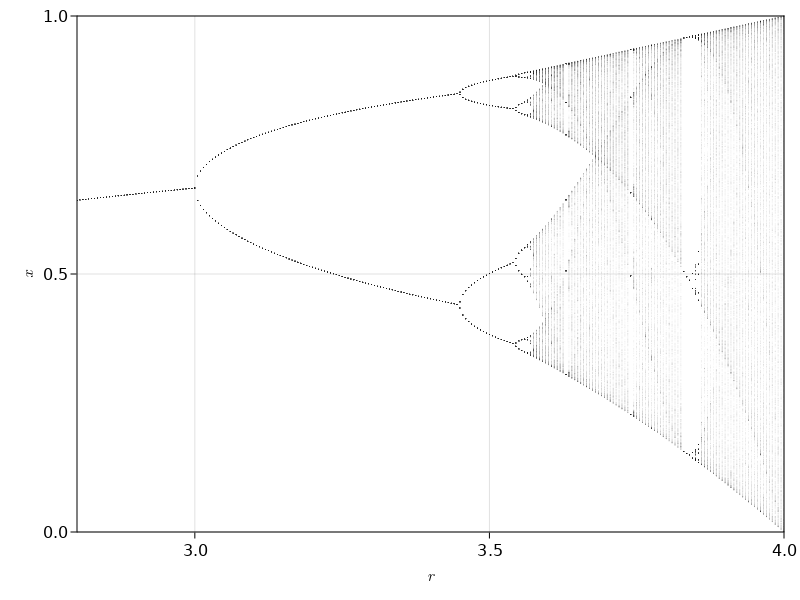

In [63]:
N = length(r_values)

# Flatten the data arrays and make them the same length
x = zeros(N * n_points)
y = zeros(N * n_points)
for j in 1:N
    x[(1 + (j - 1) * n_points):j * n_points] .= r_values[j]
    y[(1 + (j - 1) * n_points):j * n_points] .= output[j]
end

fig, ax = scatter(x, y; axis = (xlabel = L"r", ylabel = L"x"), markersize = 0.8, color = ("black", 0.05))
xlims!(ax, r_values[1], r_values[end])
ylims!(ax,0,1)
fig

Aside on modules

In [66]:
# In Plots.jl
function plot(x::Vector, y::Vector)
    # do something
end

plot (generic function with 1 method)

In [65]:
# In YourPackage.jl
function plot(x::Vector, y::Vector)
    # do something
end

plot (generic function with 1 method)

In [71]:
module MyModule
    export a

    a = 1
end

Main.MyModule

In [72]:
using .MyModule

In [73]:
a

1

End of aside on modules

#### 2.4.2. Lyapunov Exponents
`DynamicalSystems.jl` provides a number of useful methods for computing Lyapunov exponents.

In [74]:
# Maximum Lyapunov exponent of the Hénon map we defined earlier
lyapunov(henon, 10000)  # 10000 steps

0.41929992463638543

In [75]:
# Lyapunov spectrum of the Hénon map we defined earlier
lyapunovspectrum(henon, 10000)

2-element Vector{Float64}:
  0.4192247580105785
 -1.623197562336517

In [76]:
# Maximum Lyapunov exponent of the Lorenz system we defined earlier
lyapunov(lorenz63, 10000)  # 10000 seconds

0.9052304203931157

How long do we need for the algorithm to properly converge?

In [77]:
using Printf
@time for i in 1:6
    T = 10^i
    λ = lyapunov(lorenz63, T)
    @printf "T = %7is, λ = %f \n" T λ
end

T =      10s, λ = 0.045610 
T =     100s, λ = 0.811380 
T =    1000s, λ = 0.899523 
T =   10000s, λ = 0.905230 
T =  100000s, λ = 0.905770 
T = 1000000s, λ = 0.905603 
 47.148093 seconds (2.70 k allocations: 221.594 KiB)


In [78]:
# Lyapunov spectrum of the Lorenz system we defined earlier
lyapunovspectrum(lorenz63, 10000)

3-element Vector{Float64}:
   0.9053507408794503
   0.00018207823619466055
 -14.572118587717567

See how easy it is to compute Lyapunov exponents this way? With just two lines of code we can compute the full Lyapunov spectrum!

In [79]:
ds = Systems.lorenz()
lyapunovspectrum(ds, 10000)

3-element Vector{Float64}:
   0.9052368797267423
   8.971758837805676e-5
 -14.571913970662806

#### 2.4.3. Interactive GUIs

`DynamicalSystems.jl` also provides a number of great interactive utilities via the package `InteractiveDynamics.jl` for exploring dynamical systems and chaos.

In [ ]:
# Run this in VSCode!
using DynamicalSystems
using InteractiveDynamics
using OrdinaryDiffEq
using GLMakie

lorenz = Systems.lorenz()

param_ranges = Dict(
    1 => 1:0.1:30,
    2 => 0:0.1:50,
    3 => 1:0.01:10.0,
)
param_names = Dict(1 => "σ", 2 => "ρ", 3 => "β")

diffeq = (alg = Tsit5(), adaptive = false, dt = 0.01)  # args for DiffEq solvers

interactive_evolution(lorenz, [rand(3), rand(3)], ps = param_ranges, diffeq = diffeq, pnames = param_names)

In [ ]:
# Run this in VSCode!
using DynamicalSystems
using InteractiveDynamics
using OrdinaryDiffEq
using GLMakie

henon = Systems.henon()

i = 1                    # First variable
p_index = 1              # First parameter
p_min, p_max = 0.8, 1.4  # Min,max value of parameter

title = "Orbit Diagram for the Hénon map"

interactive_orbitdiagram(henon, p_index, p_min, p_max, i, parname = "a", title = t)

## 3. Further Reading <a class="anchor" id="further-reading"></a>
1. [Julia - Modules](https://docs.julialang.org/en/v1/manual/modules/)
2. [Julia - Code Loading](https://docs.julialang.org/en/v1/manual/code-loading/)
3. [Julia - Variable Scoping](https://docs.julialang.org/en/v1/manual/variables-and-scoping/)
4. [Namespaces in Programming Languages (Wikipeda)](https://en.wikipedia.org/wiki/Namespace#In_programming_languages)
5. [DynamicalSystems.jl docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/)